# ClinVar Preprocessing

### Description:
This notebook processes a list of variants from ClinVar and outputs a CSV with mutated sequences, annotations, etc for scoring

It then separates those variants into separate files for scoring, one file per NCBI RefSeq ID.

Filtered online on ClinVar using following query:

`("inframe deletion"[Molecular consequence] OR "inframe indel"[Molecular consequence] OR "inframe insertion"[Molecular consequence])`

(previously I was filtering the full clinvar_variant_summary.txt file from their FTP server manually using the p.() string)

Combining 23_02_06_Step1_process_clinvar.ipynb and Step2_split_variants_by_refseq_id.ipynb into one notebook for NeurIPS dataset track

## Notebook inputs/outputs


In [1]:
# If not already, download the RefSeq-UniProt mapping file
# !wget https://ftp.ncbi.nlm.nih.gov/refseq/uniprotkb/gene_refseq_uniprotkb_collab.gz
# !mv gene_refseq_uniprotkb_collab.gz {DATA_DIR}

In [2]:
# Input files
# DATA_DIR = "/n/groups/marks/projects/indels_human/indels_benchmark/data/ClinVar/"
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/ClinVar/"
# The file downloaded from ClinVar querying for indels
clinvar_query = DATA_DIR+"raw/clinvar_result_inframe_indels_20230206.txt"
# NCBI RefSeq sequences (downloaded from NCBI FTP server)
grch38_protein_file = DATA_DIR + "raw/GRCh38_latest_protein.faa"

refseq_sequences_mapping = ROOT_DIR + "data/mappings/refseq_mapping_gff.tsv"
# Downloaded from NCBI FTP server (see above)
refseq_uniprot_mapping = ROOT_DIR + "data/reference_files/gene_refseq_uniprotkb_collab.gz"
# For checking STRs (see bottom of notebook)
hg38_assembly_reference = ROOT_DIR + "data/reference_files/genome_assemblies/hg38.fa"

# Intermediate files
refseq_uniprot_protein_dict_pickle = DATA_DIR + "intermediate_files/refseq_uniprot_protein_dict.pkl"

# Output files
PROCESSED_DATA_DIR = ROOT_DIR + "processed_data/ClinVar/"
clinvar_query_mapped_out = PROCESSED_DATA_DIR + "clinvar_indel_query_mapped_20230206.csv"
clinvar_filtered_variants_out = PROCESSED_DATA_DIR + "clinvar_indel_query_mapped_filter_significance_duplications_all_annotations_20230206.csv"  # The genes with >=1 pathogenic, all annotations
clinvar_only_significant_variants_out = PROCESSED_DATA_DIR + "clinvar_indel_query_mapped_filter_significance_duplications_20230206.csv"

# For scoring:
# Choose either the >=1 pathogenic filter, or the >=1 pathogenic + significant annotation file
file_to_score = clinvar_only_significant_variants_out
# file_to_score = clinvar_filtered_variants_out

# Outputs
per_protein_out_folder = PROCESSED_DATA_DIR + "by_refseq/"
# File containing the wt sequences for each RefSeq id
fasta_refseq_sequences = PROCESSED_DATA_DIR + "2023-05-04_unique_protein_sequences_by_refseq_id.fasta"
# Tranception mapping file
tranception_refseq_id_file = PROCESSED_DATA_DIR + "2023-05-05-tranception_mapping_by_refseq_id.csv"

In [3]:
import gzip
import os
import pickle
import re
# Change path so that we can import clinvar_utils
import sys
import time
sys.path.append('..')

from Bio import SeqIO
from Bio.SeqUtils import IUPACData
import numpy as np
import pandas as pd
from pyfaidx import Fasta
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from utils.mutated_sequence_utils import hgvs_regex, refseq_regex, insert, delete, delins, duplicate

# For when we want to do sanity checks with `df["col"].str.contains(regex)` where regex contains match groups
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

# For checking STRs (see bottom of notebook)
hg38 = Fasta(hg38_assembly_reference)

start = time.perf_counter()

In [4]:
df_clinvar_query = pd.read_table(clinvar_query)
print(len(df_clinvar_query))
df_clinvar_query.head()

18624


,Name,Gene(s),Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,GRCh38Location,VariationID,AlleleID(s),dbSNP ID,Canonical SPDI,Unnamed: 15
0,NM_001385641.1(SAMD11):c.919_921dup (p.Arg307dup),SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Aug 30, ...","criteria provided, single submitter",VCV001370201,1,871225 - 871226,1,935845 - 935846,1370201,1352540,NaN,NC_000001.11:935845:GCCGC:GCCGCCGC,NaN
1,NM_001385641.1(SAMD11):c.1195+9_1195+10insTACC...,SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Nov 8, 2...","criteria provided, single submitter",VCV001479161,1,874778 - 874779,1,939398 - 939399,1479161,1426532,NaN,NC_000001.11:939398:CCTCCCCAGCCACGGTGAGGACC:CC...,NaN
2,NM_001385641.1(SAMD11):c.1332_1343dup (p.Ala44...,SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Oct 13, ...","criteria provided, single submitter",VCV001467580,1,876651 - 876652,1,941271 - 941272,1467580,1357086,NaN,NC_000001.11:941271:GCCGCCCCAGCTGCCGCCCC:GCCGC...,NaN
3,NM_001385641.1(SAMD11):c.1421_1423del (p.Pro47...,SAMD11,"P475del, P311del, P474del",not provided,"Uncertain significance(Last reviewed: Oct 10, ...","criteria provided, single submitter",VCV001409170,1,877576 - 877578,1,942196 - 942198,1409170,1496959,NaN,NC_000001.11:942195:CCCCC:CC,NaN
4,NM_001385641.1(SAMD11):c.1534_1536dup (p.Arg51...,SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Aug 28, ...","criteria provided, single submitter",VCV001378326,1,877847 - 877848,1,942467 - 942468,1378326,1492756,NaN,NC_000001.11:942467:GCGG:GCGGCGG,NaN


In [5]:
# The last column is empty
assert df_clinvar_query["Unnamed: 15"].isna().all()
df_clinvar_query = df_clinvar_query.drop(columns=["Unnamed: 15"]).copy()

In [6]:
df_clinvar_query['Review status'].value_counts()

criteria provided, single submitter                     12589
criteria provided, multiple submitters, no conflicts     3136
no assertion criteria provided                           1559
criteria provided, conflicting interpretations            992
no assertion provided                                     201
reviewed by expert panel                                  120
no interpretation for the single variant                   25
practice guideline                                          2
Name: Review status, dtype: int64

In [7]:
# From https://www.ncbi.nlm.nih.gov/clinvar/docs/review_status/#ac
# four	practice guideline	practice guideline
# three	reviewed by expert panel	reviewed by expert panel
# two	criteria provided, multiple submitters, no conflicts	Two or more submitters with assertion criteria and evidence (or a public contact) provided the same interpretation.
# one	criteria provided, conflicting interpretations	Multiple submitters provided assertion criteria and evidence (or a public contact) but there are conflicting interpretations. The independent values are enumerated for clinical significance.
# one	criteria provided, single submitter	One submitter provided an interpretation with assertion criteria and evidence (or a public contact).
# none	no assertion for the individual variant	The allele was not interpreted directly in any submission; it was submitted to ClinVar only as a component of a haplotype or a genotype.
# none	no assertion criteria provided	The allele was included in a submission with an interpretation but without assertion criteria and evidence (or a public contact).
# none	no assertion provided	The allele was included in a submission that did not provide an interpretation.
review_stars_mapping = {
    "practice guideline": 4,
    "reviewed by expert panel": 3, 
    "criteria provided, multiple submitters, no conflicts": 2,
    "criteria provided, conflicting interpretations": 1,
    "criteria provided, single submitter": 1,
    "no assertion provided": 0,
    "no interpretation for the single variant": 0,
    "no assertion criteria provided": 0,
}

In [8]:
df_clinvar_query["Stars"] = df_clinvar_query["Review status"].apply(review_stars_mapping.get)

### Clinical significance

In [9]:
split_significance_regex = r"^(.+)\((.+)\)$"
df_clinvar_query[['Clinical significance', 'Last reviewed']] = df_clinvar_query["Clinical significance (Last reviewed)"].str.extract(split_significance_regex)
df_clinvar_query[['Clinical significance', 'Last reviewed']]

,Clinical significance,Last reviewed
0,Uncertain significance,"Last reviewed: Aug 30, 2021"
1,Uncertain significance,"Last reviewed: Nov 8, 2021"
2,Uncertain significance,"Last reviewed: Oct 13, 2021"
3,Uncertain significance,"Last reviewed: Oct 10, 2021"
4,Uncertain significance,"Last reviewed: Aug 28, 2021"
...,...,...
18619,Pathogenic,"Last reviewed: Feb 1, 1993"
18620,Pathogenic,"Last reviewed: Jun 1, 2019"
18621,Uncertain significance,"Last reviewed: Sep 14, 2015"
18622,Uncertain significance,"Last reviewed: Feb 9, 2021"


In [10]:
df_clinvar_query['Clinical significance'].value_counts()

Uncertain significance                                       11972
Pathogenic                                                    1380
Likely pathogenic                                             1200
Likely benign                                                 1041
Conflicting interpretations of pathogenicity                  1004
Benign                                                         725
Benign/Likely benign                                           354
Pathogenic/Likely pathogenic                                   218
drug response                                                   42
other                                                           24
not provided                                                    17
risk factor                                                      9
Likely risk allele                                               3
Affects                                                          2
Pathogenic; drug response                                     

In [11]:
# significance_categories_clean = ["Uncertain significance", "Pathogenic", "Likely pathogenic", "Likely benign", "Benign", "Benign/Likely benign", "Pathogenic/Likely pathogenic"]
pathogenic_categories = ["Pathogenic", "Likely pathogenic", "Pathogenic/Likely pathogenic"]
benign_categories = ["Benign", "Likely benign", "Benign/Likely benign"]

## Basic stats:

In [12]:
with pd.option_context('display.float_format', '{:.2%}'.format):
    display(df_clinvar_query['Clinical significance'].value_counts(normalize=True, dropna=False))
# 68% Uncertain, 7% pathogenic

Uncertain significance                                      64.28%
Pathogenic                                                   7.41%
Likely pathogenic                                            6.44%
Likely benign                                                5.59%
Conflicting interpretations of pathogenicity                 5.39%
Benign                                                       3.89%
NaN                                                          3.33%
Benign/Likely benign                                         1.90%
Pathogenic/Likely pathogenic                                 1.17%
drug response                                                0.23%
other                                                        0.13%
not provided                                                 0.09%
risk factor                                                  0.05%
Likely risk allele                                           0.02%
Pathogenic; other                                            0

In [13]:
def filter_significance(group):
    return (group['Clinical significance'].isin(pathogenic_categories).sum() >= 1) and (group['Clinical significance'].isin(benign_categories).sum() >= 1)
print("Number of genes with >= 1 pathogenic/likely pathogenic and >= 1 benign/likely benign")
df_clinvar_query.groupby("Gene(s)").apply(filter_significance).sum()

Number of genes with >= 1 pathogenic/likely pathogenic and >= 1 benign/likely benign


204

**Switch from ≥1B1P filter to just ≥1P filter**

In [14]:
def filter_significance(group):
    return (group['Clinical significance'].isin(pathogenic_categories).sum() >= 1)
print("Number of genes with >= 1 pathogenic/likely pathogenic ")
df_clinvar_query.groupby("Gene(s)").apply(filter_significance).sum()

Number of genes with >= 1 pathogenic/likely pathogenic 


1143

In [15]:
def filter_significance_stars(group):
    subset = group[group["Stars"] >= 2]
    return (subset['Clinical significance'].isin(pathogenic_categories).sum() >= 1)
print("Number of genes with >= 2 stars; >= 1 pathogenic/likely pathogenic")
df_clinvar_query.groupby("Gene(s)").apply(filter_significance_stars).sum()

Number of genes with >= 2 stars; >= 1 pathogenic/likely pathogenic


286

## Process AA annotations

In [16]:
# Clean up by using predicted AA change
df_clinvar_query['hgvs_valid'] = df_clinvar_query['Name'].str.contains(hgvs_regex)
df_clinvar_query['protein_variant'] = df_clinvar_query['Name'].str.extract(hgvs_regex)
print(f"{df_clinvar_query['hgvs_valid'].mean():.2%} valid protein annotation")

98.83% valid protein annotation


/tmp/ipykernel_30732/1721049914.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_clinvar_query['hgvs_valid'] = df_clinvar_query['Name'].str.contains(hgvs_regex)


In [17]:
filter_cols = []
synon_stop_regex = "=|\*|Ter"
df_clinvar_query['inframe_dup'] = df_clinvar_query['protein_variant'].str.contains("dup")
# Note: Not dropping duplications for now, can drop later
# filter_cols.append('inframe_dup')
df_clinvar_query['inframe_synon_stop'] = df_clinvar_query['protein_variant'].str.contains(synon_stop_regex)
filter_cols.append('inframe_synon_stop')
df_clinvar_query['question_mark'] = df_clinvar_query['protein_variant'].str.contains("\?")
filter_cols.append('question_mark')
# Square bracket = repeats: http://varnomen.hgvs.org/recommendations/protein/variant/repeated/ TODO can include this later
df_clinvar_query['square_bracket'] = df_clinvar_query['protein_variant'].str.contains("\[\d+\]")
filter_cols.append('square_bracket')
df_clinvar_query['hgvs_frameshift'] = df_clinvar_query['protein_variant'].str.contains("fs")
filter_cols.append('hgvs_frameshift')

df_clinvar_query['invalid_aa'] = df_clinvar_query['protein_variant'].str.contains("X")
filter_cols.append('invalid_aa')

In [18]:
print("Rows before filtering:", df_clinvar_query['hgvs_valid'].sum())
print(f"Number of AA duplication indels: {df_clinvar_query['inframe_dup'].sum()}")

print("Filtering out:", filter_cols)
df_clinvar_clean = df_clinvar_query[df_clinvar_query['hgvs_valid']].copy()
for col in filter_cols:
    print(f"{col}: Dropping rows {df_clinvar_query[col].sum()} / {len(df_clinvar_query)} = {df_clinvar_query[col].mean():.2%}")
    df_clinvar_clean = df_clinvar_clean[~df_clinvar_clean[col].astype(bool)]

# df_clinvar_clean

Rows before filtering: 18407
Number of AA duplication indels: 3165
Filtering out: ['inframe_synon_stop', 'question_mark', 'square_bracket', 'hgvs_frameshift', 'invalid_aa']
inframe_synon_stop: Dropping rows 201 / 18624 = 1.09%
question_mark: Dropping rows 0 / 18624 = 0.00%
square_bracket: Dropping rows 1136 / 18624 = 6.17%
hgvs_frameshift: Dropping rows 7 / 18624 = 0.04%
invalid_aa: Dropping rows 29 / 18624 = 0.16%


In [19]:
print(len(df_clinvar_clean), "rows after filtering")

17039 rows after filtering


In [20]:
# Sanity check that we don't have invalid amino acid characters

# genes_with_invalid_aas = df_clinvar_clean[df_clinvar_clean["invalid_aa"] == True]["Gene(s)"].unique()
df_clinvar_clean[df_clinvar_clean["invalid_aa"] == True][["Gene(s)","protein_variant"]]

,Gene(s),protein_variant


## Annotate insertion, deletion, delins etc

In [21]:
# Annotate as ins, del, delins
# Note: Could also make this one column with delins/ins/del values and no NaNs
df_clinvar_clean['inframe_delins'] = df_clinvar_clean['protein_variant'].str.contains("delins")
df_clinvar_clean['inframe_ins'] = df_clinvar_clean['protein_variant'].str.contains("ins") & ~df_clinvar_clean['inframe_delins']
df_clinvar_clean['inframe_del'] = df_clinvar_clean['protein_variant'].str.contains("del") & ~df_clinvar_clean['inframe_delins']
# Sanity-check deletions (more difficult to sanity-check insertions as the string doesn't end with ins
assert df_clinvar_clean['protein_variant'].str.endswith("del").equals(df_clinvar_clean['inframe_del'])

# Cast all to bool
df_clinvar_clean['inframe_delins'] = df_clinvar_clean['inframe_delins'].astype(bool)
df_clinvar_clean['inframe_ins'] = df_clinvar_clean['inframe_ins'].astype(bool)
df_clinvar_clean['inframe_del'] = df_clinvar_clean['inframe_del'].astype(bool)
df_clinvar_clean['inframe_dup'] = df_clinvar_clean['inframe_dup'].astype(bool)

# Check what's left over, there shouldn't be anything
assert not (~(df_clinvar_clean['inframe_delins'] | df_clinvar_clean['inframe_ins'] | df_clinvar_clean['inframe_del'] | df_clinvar_clean['inframe_dup'])).any()

In [22]:
# Get counts of ins / del / insdel
print(f"Number of deletions: {df_clinvar_clean['inframe_del'].sum()} / {len(df_clinvar_clean)} \t= {df_clinvar_clean['inframe_del'].mean():.2%}")
print(f"Number of insertions: {df_clinvar_clean['inframe_ins'].sum()} / {len(df_clinvar_clean)} \t= {df_clinvar_clean['inframe_ins'].mean():.2%}")
print(f"Number of deletion-insertions (many of them substitutions): {df_clinvar_clean['inframe_delins'].sum()} / {len(df_clinvar_clean)} \t= {df_clinvar_clean['inframe_delins'].mean():.2%}")
print(f"Number of duplications: {df_clinvar_clean['inframe_dup'].sum()} / {len(df_clinvar_clean)} \t= {df_clinvar_clean['inframe_dup'].mean():.2%}")

Number of deletions: 11457 / 17039 	= 67.24%
Number of insertions: 1277 / 17039 	= 7.49%
Number of deletion-insertions (many of them substitutions): 1140 / 17039 	= 6.69%
Number of duplications: 3165 / 17039 	= 18.58%


In [23]:
df_clinvar_clean["Gene(s)"].nunique()

3161

## Get AA positions

In [24]:
# Parse starting AA (3 letter Abc) and position
pos_regex = "([A-Z][a-z]{2})(\d+)"
assert df_clinvar_clean['protein_variant'].str.contains(pos_regex).all()

df_clinvar_clean[['aa_wt_start_3letter', 'pos_start']] = df_clinvar_clean['protein_variant'].str.extract(pos_regex)
df_clinvar_clean['pos_start'] = df_clinvar_clean['pos_start'].astype('int')
df_clinvar_clean[['protein_variant', 'aa_wt_start_3letter', 'pos_start']]
df_clinvar_clean[['protein_variant','aa_wt_start_3letter','pos_start']][df_clinvar_clean['aa_wt_start_3letter'] == 'Xaa']

/tmp/ipykernel_30732/3346771229.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  assert df_clinvar_clean['protein_variant'].str.contains(pos_regex).all()


,protein_variant,aa_wt_start_3letter,pos_start


In [25]:
IUPACData.protein_letters_3to1

{'Ala': 'A',
 'Cys': 'C',
 'Asp': 'D',
 'Glu': 'E',
 'Phe': 'F',
 'Gly': 'G',
 'His': 'H',
 'Ile': 'I',
 'Lys': 'K',
 'Leu': 'L',
 'Met': 'M',
 'Asn': 'N',
 'Pro': 'P',
 'Gln': 'Q',
 'Arg': 'R',
 'Ser': 'S',
 'Thr': 'T',
 'Val': 'V',
 'Trp': 'W',
 'Tyr': 'Y'}

In [26]:
df_clinvar_clean['aa_wt_start'] = df_clinvar_clean['aa_wt_start_3letter'].apply(lambda s: IUPACData.protein_letters_3to1[s])  # Using [s] instead of .get since .get silently returns NaNs
print(len(df_clinvar_clean))
df_clinvar_clean.head()

17039


,Name,Gene(s),Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,question_mark,square_bracket,hgvs_frameshift,invalid_aa,inframe_delins,inframe_ins,inframe_del,aa_wt_start_3letter,pos_start,aa_wt_start
0,NM_001385641.1(SAMD11):c.919_921dup (p.Arg307dup),SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Aug 30, ...","criteria provided, single submitter",VCV001370201,1,871225 - 871226,1,...,False,False,False,False,False,False,False,Arg,307,R
2,NM_001385641.1(SAMD11):c.1332_1343dup (p.Ala44...,SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Oct 13, ...","criteria provided, single submitter",VCV001467580,1,876651 - 876652,1,...,False,False,False,False,False,False,False,Ala,445,A
3,NM_001385641.1(SAMD11):c.1421_1423del (p.Pro47...,SAMD11,"P475del, P311del, P474del",not provided,"Uncertain significance(Last reviewed: Oct 10, ...","criteria provided, single submitter",VCV001409170,1,877576 - 877578,1,...,False,False,False,False,False,False,True,Pro,474,P
4,NM_001385641.1(SAMD11):c.1534_1536dup (p.Arg51...,SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Aug 28, ...","criteria provided, single submitter",VCV001378326,1,877847 - 877848,1,...,False,False,False,False,False,False,False,Arg,512,R
5,NM_001385641.1(SAMD11):c.1585_1587del (p.Lys52...,SAMD11,"K366del, K529del, K530del",not provided,"Uncertain significance(Last reviewed: Sep 18, ...","criteria provided, single submitter",VCV000849483,1,877968 - 877970,1,...,False,False,False,False,False,False,True,Lys,529,K


In [27]:
# Stop codons - ignore
assert not df_clinvar_clean['aa_wt_start'].isna().any()

## Change all 3-letter amino acids to 1-letter amino acids

In [28]:
df_clinvar_clean['protein_variant_1letter'] = df_clinvar_clean['protein_variant']
for aa3, aa1 in tqdm(IUPACData.protein_letters_3to1.items()):
    df_clinvar_clean['protein_variant_1letter'] = df_clinvar_clean['protein_variant_1letter'].str.replace(aa3, aa1, regex=False)
assert not df_clinvar_clean['protein_variant_1letter'].isna().any()

  0%|          | 0/20 [00:00<?, ?it/s]

## Map RefSeq ids to sequences

In [29]:
# Extract all sequence IDs
matches = df_clinvar_clean["Name"].str.contains(refseq_regex, regex=True)
assert matches.any()
assert matches.all()

df_clinvar_clean['refseq_id'] = df_clinvar_clean["Name"].str.extract(refseq_regex)
assert not df_clinvar_clean['refseq_id'].isna().any()

/tmp/ipykernel_30732/3474002911.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matches = df_clinvar_clean["Name"].str.contains(refseq_regex, regex=True)


In [30]:
df_refseq_mapping = pd.read_csv(refseq_sequences_mapping, delimiter='\t', low_memory=False)
display(df_refseq_mapping.columns)
df_refseq_mapping.head()

Index(['protein', 'length', 'definition', 'gene', 'coded_by', 'GeneID', 'HGNC',
       'MIM', 'gene_synonym', 'note', 'CCDS', 'IMGT/GENE-DB', 'GO_function',
       'exception', 'transl_table', 'ribosomal_slippage', 'GO_component',
       'GO_process', 'mrna', 'coding_pos'],
      dtype='object')

,protein,length,definition,gene,coded_by,GeneID,HGNC,MIM,gene_synonym,note,CCDS,IMGT/GENE-DB,GO_function,exception,transl_table,ribosomal_slippage,GO_component,GO_process,mrna,coding_pos
0,XP_016865305.1,497,ankyrin repeat and death domain-containing pro...,ANKDD1B,XM_017009816.2:183..1676,728780,32525.0,619920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XM_017009816.2,183..1676
1,XP_011541920.1,484,ankyrin repeat and death domain-containing pro...,ANKDD1B,XM_011543618.3:183..1637,728780,32525.0,619920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XM_011543618.3,183..1637
2,XP_011541925.1,383,ankyrin repeat and death domain-containing pro...,ANKDD1B,XM_011543623.3:183..1334,728780,32525.0,619920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XM_011543623.3,183..1334
3,XP_047273642.1,312,ankyrin repeat and death domain-containing pro...,ANKDD1B,XM_047417686.1:424..1362,728780,32525.0,619920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XM_047417686.1,424..1362
4,XP_011512416.1,971,complement component C6 isoform X1 [Homo sapiens],C6,XM_011514114.4:270..3185,729,1339.0,217050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XM_011514114.4,270..3185


In [31]:
df_clinvar_clean.columns

Index(['Name', 'Gene(s)', 'Protein change', 'Condition(s)',
       'Clinical significance (Last reviewed)', 'Review status', 'Accession',
       'GRCh37Chromosome', 'GRCh37Location', 'GRCh38Chromosome',
       'GRCh38Location', 'VariationID', 'AlleleID(s)', 'dbSNP ID',
       'Canonical SPDI', 'Stars', 'Clinical significance', 'Last reviewed',
       'hgvs_valid', 'protein_variant', 'inframe_dup', 'inframe_synon_stop',
       'question_mark', 'square_bracket', 'hgvs_frameshift', 'invalid_aa',
       'inframe_delins', 'inframe_ins', 'inframe_del', 'aa_wt_start_3letter',
       'pos_start', 'aa_wt_start', 'protein_variant_1letter', 'refseq_id'],
      dtype='object')

In [32]:
# Merge to get mappings
column_mapper = {'protein': 'refseq_protein_id', 'mrna': 'refseq_mrna_id'} # Can also rename 'gene'
# keep_cols = column_mapper.values + ["length", "definition", "gene", "gene_synonym", "coded_by", "note", "CCDS]
df_merged = df_clinvar_clean.merge(df_refseq_mapping.rename(columns=column_mapper), how='left', left_on='refseq_id', right_on='refseq_mrna_id')
df_merged

,Name,Gene(s),Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,CCDS,IMGT/GENE-DB,GO_function,exception,transl_table,ribosomal_slippage,GO_component,GO_process,refseq_mrna_id,coding_pos
0,NM_001385641.1(SAMD11):c.919_921dup (p.Arg307dup),SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Aug 30, ...","criteria provided, single submitter",VCV001370201,1,871225 - 871226,1,...,CCDS90834.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NM_001385641.1,510..3044
1,NM_001385641.1(SAMD11):c.1332_1343dup (p.Ala44...,SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Oct 13, ...","criteria provided, single submitter",VCV001467580,1,876651 - 876652,1,...,CCDS90834.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NM_001385641.1,510..3044
2,NM_001385641.1(SAMD11):c.1421_1423del (p.Pro47...,SAMD11,"P475del, P311del, P474del",not provided,"Uncertain significance(Last reviewed: Oct 10, ...","criteria provided, single submitter",VCV001409170,1,877576 - 877578,1,...,CCDS90834.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NM_001385641.1,510..3044
3,NM_001385641.1(SAMD11):c.1534_1536dup (p.Arg51...,SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Aug 28, ...","criteria provided, single submitter",VCV001378326,1,877847 - 877848,1,...,CCDS90834.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NM_001385641.1,510..3044
4,NM_001385641.1(SAMD11):c.1585_1587del (p.Lys52...,SAMD11,"K366del, K529del, K530del",not provided,"Uncertain significance(Last reviewed: Sep 18, ...","criteria provided, single submitter",VCV000849483,1,877968 - 877970,1,...,CCDS90834.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NM_001385641.1,510..3044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17034,NM_000132.4(F8):c.2009TCT[2] (p.Phe672del),F8,F672del,Hereditary factor VIII deficiency disease,"Pathogenic(Last reviewed: Feb 1, 1993)",no assertion criteria provided,VCV000010243,X,154176069 - 154176071,X,...,CCDS35457.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NM_000132.4,172..7227
17035,NM_000132.4(F8):c.1467_1472dup (p.Arg490_Pro49...,F8,NaN,Hereditary factor VIII deficiency disease,"Pathogenic(Last reviewed: Jun 1, 2019)",no assertion criteria provided,VCV000973799,X,154189414 - 154189415,X,...,CCDS35457.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NM_000132.4,172..7227
17036,NM_171998.4(RAB39B):c.624GAG[1] (p.Arg210del),RAB39B,R210del,"Parkinson disease, X-linked dominant","Uncertain significance(Last reviewed: Sep 14, ...","criteria provided, single submitter",VCV000218364,X,154490101 - 154490103,X,...,CCDS14766.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NM_171998.4,204..845
17037,NM_171998.4(RAB39B):c.174_176del (p.Ile58_Lys5...,RAB39B,NaN,not provided,"Uncertain significance(Last reviewed: Feb 9, 2...","criteria provided, single submitter",VCV001309370,X,154493398 - 154493400,X,...,CCDS14766.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NM_171998.4,204..845


In [33]:
# Are there even any aliases here?
df_merged['Gene(s)'].str.contains("\|").sum()

1687

### Quality checks

In [34]:
# Check number of sequences mapped
df_merged['has_mrna_mapping'] = ~df_merged['refseq_mrna_id'].isna()
print(f"{(~df_merged['has_mrna_mapping']).sum()} / {len(df_merged)} mRNA ids not mapped.")
# TODO Can handle these 20 missed mappings later
print("Unmapped sequences:")
display(df_merged.loc[df_merged['refseq_mrna_id'].isna()]['Name'])

df_clinvar_clean_mapped = df_merged[df_merged['has_mrna_mapping']].copy()

# Check Gene names match
# NOTE: Can't check Gene IDs as with clinvar_variant_summary as this table doesn't include them. Consider getting them for correctness
def gene_match(row):
    # Either the gene in the mapping file is in the ClinVar aliases `Gene(s)`
    # or ClinVar gene in mapping file aliases
    return row["gene"] in row["Gene(s)"].split("|") or any(g in row["Gene(s)"] for g in row["gene_synonym"].split("; "))

df_clinvar_clean_mapped['gene_symbol_match'] = df_clinvar_clean_mapped.apply(gene_match, axis=1)
print(f"{df_clinvar_clean_mapped['gene_symbol_match'].sum()} / {len(df_clinvar_clean_mapped)} gene name matches")

21 / 17039 mRNA ids not mapped.
Unmapped sequences:


142      NM_004565.2(PEX14):c.987_995dup (p.Asp331_Asp3...
3421     NM_023067.3(FOXL2):c.684684AGCTGCGGCTGCAGC[3] ...
5786     NM_003194.4(TBP):c.276_281dup (p.Gln95_Ala96in...
6203     NM_000466.2(PEX1):c.2010_2018del (p.Ala672_Pro...
6393        NM_000492.3(CFTR):c.1521_1523del (p.Phe508del)
6541     NM_172057.2(KCNH2):c.2078_2080dup (p.Arg693_Pr...
6566     NM_000238.3(KCNH2):c.1498_1524del27 (p.Ile500_...
7546        NM_003640.4(ELP1):c.2370_2372del (p.Glu790del)
8607     NM_002457.4(MUC2):c.4792_5220del (p.Pro1598_Pr...
8754     NM_000543.4(SMPD1):c.126_143del (p.Ala44_Leu49...
8792     NM_000525.3(KCNJ11):c.1138_1143dup (p.Lys381_P...
10087    NM_000277.2(PAH):c.206_211dup (p.Ser70_Arg71in...
10719    NM_004643.3(PABPN1):c.3GGC[11] (p.Ala11_Gly12i...
10721     NM_004643.3(PABPN1):c.3GGC[10] (p.Ala9_Ala11dup)
11612     NM_020843.3(SCAPER):c.1859_1861del (p.Glu620del)
11818    NM_000558.3(HBA1):c.114_115insGAA (p.Pro38_Thr...
12449    NM_002968.2(SALL1):c.466_477dup (p.Ser159_Gly1.

17018 / 17018 gene name matches


## Get protein sequence from RefSeq protein ID

In [35]:
# Load NCBI protein refseq id mapping
!head {grch38_protein_file}
fasta_38_dict = SeqIO.to_dict(SeqIO.parse(grch38_protein_file, "fasta"))
next(iter(fasta_38_dict.items()))

>NP_000005.3 alpha-2-macroglobulin isoform a precursor [Homo sapiens]
MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEKGCVLLSYLNETVTVSASLESVRGNRSLFTDLEAE
NDVLHCVAFAVPKSSSNEEVMFLTVQVKGPTQEFKKRTTVMVKNEDSLVFVQTDKSIYKPGQTVKFRVVSMDENFHPLNE
LIPLVYIQDPKGNRIAQWQSFQLEGGLKQFSFPLSSEPFQGSYKVVVQKKSGGRTEHPFTVEEFVLPKFEVQVTVPKIIT
ILEEEMNVSVCGLYTYGKPVPGHVTVSICRKYSDASDCHGEDSQAFCEKFSGQLNSHGCFYQQVKTKVFQLKRKEYEMKL
HTEAQIQEEGTVVELTGRQSSEITRTITKLSFVKVDSHFRQGIPFFGQVRLVDGKGVPIPNKVIFIRGNEANYYSNATTD
EHGLVQFSINTTNVMGTSLTVRVNYKDRSPCYGYQWVSEEHEEAHHTAYLVFSPSKSFVHLEPMSHELPCGHTQTVQAHY
ILNGGTLLGLKKLSFYYLIMAKGGIVRTGTHGLLVKQEDMKGHFSISIPVKSDIAPVARLLIYAVLPTGDVIGDSAKYDV
ENCLANKVDLSFSPSQSLPASHAHLRVTAAPQSVCALRAVDQSVLLMKPDAELSASSVYNLLPEKDLTGFPGPLNDQDNE
DCINRHNVYINGITYTPVSSTNEKDMYSFLEDMGLKAFTNSKIRKPKMCPQLQQYEMHGPEGLRVGFYESDVMGRGHARL


('NP_000005.3',
 SeqRecord(seq=Seq('MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEKGCVLLSYL...GNA'), id='NP_000005.3', name='NP_000005.3', description='NP_000005.3 alpha-2-macroglobulin isoform a precursor [Homo sapiens]', dbxrefs=[]))

In [36]:
df_clinvar_clean_mapped['protein_sequence'] = df_clinvar_clean_mapped['refseq_protein_id'].apply(lambda s: str(fasta_38_dict[s].seq))
df_clinvar_clean_mapped

,Name,Gene(s),Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,exception,transl_table,ribosomal_slippage,GO_component,GO_process,refseq_mrna_id,coding_pos,has_mrna_mapping,gene_symbol_match,protein_sequence
0,NM_001385641.1(SAMD11):c.919_921dup (p.Arg307dup),SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Aug 30, ...","criteria provided, single submitter",VCV001370201,1,871225 - 871226,1,...,NaN,NaN,NaN,NaN,NaN,NM_001385641.1,510..3044,True,True,MPAVKKEFPGREDLALALATFHPTLAALPLPPLPGYLAPLPAAAAL...
1,NM_001385641.1(SAMD11):c.1332_1343dup (p.Ala44...,SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Oct 13, ...","criteria provided, single submitter",VCV001467580,1,876651 - 876652,1,...,NaN,NaN,NaN,NaN,NaN,NM_001385641.1,510..3044,True,True,MPAVKKEFPGREDLALALATFHPTLAALPLPPLPGYLAPLPAAAAL...
2,NM_001385641.1(SAMD11):c.1421_1423del (p.Pro47...,SAMD11,"P475del, P311del, P474del",not provided,"Uncertain significance(Last reviewed: Oct 10, ...","criteria provided, single submitter",VCV001409170,1,877576 - 877578,1,...,NaN,NaN,NaN,NaN,NaN,NM_001385641.1,510..3044,True,True,MPAVKKEFPGREDLALALATFHPTLAALPLPPLPGYLAPLPAAAAL...
3,NM_001385641.1(SAMD11):c.1534_1536dup (p.Arg51...,SAMD11,NaN,not provided,"Uncertain significance(Last reviewed: Aug 28, ...","criteria provided, single submitter",VCV001378326,1,877847 - 877848,1,...,NaN,NaN,NaN,NaN,NaN,NM_001385641.1,510..3044,True,True,MPAVKKEFPGREDLALALATFHPTLAALPLPPLPGYLAPLPAAAAL...
4,NM_001385641.1(SAMD11):c.1585_1587del (p.Lys52...,SAMD11,"K366del, K529del, K530del",not provided,"Uncertain significance(Last reviewed: Sep 18, ...","criteria provided, single submitter",VCV000849483,1,877968 - 877970,1,...,NaN,NaN,NaN,NaN,NaN,NM_001385641.1,510..3044,True,True,MPAVKKEFPGREDLALALATFHPTLAALPLPPLPGYLAPLPAAAAL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17034,NM_000132.4(F8):c.2009TCT[2] (p.Phe672del),F8,F672del,Hereditary factor VIII deficiency disease,"Pathogenic(Last reviewed: Feb 1, 1993)",no assertion criteria provided,VCV000010243,X,154176069 - 154176071,X,...,NaN,NaN,NaN,NaN,NaN,NM_000132.4,172..7227,True,True,MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...
17035,NM_000132.4(F8):c.1467_1472dup (p.Arg490_Pro49...,F8,NaN,Hereditary factor VIII deficiency disease,"Pathogenic(Last reviewed: Jun 1, 2019)",no assertion criteria provided,VCV000973799,X,154189414 - 154189415,X,...,NaN,NaN,NaN,NaN,NaN,NM_000132.4,172..7227,True,True,MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...
17036,NM_171998.4(RAB39B):c.624GAG[1] (p.Arg210del),RAB39B,R210del,"Parkinson disease, X-linked dominant","Uncertain significance(Last reviewed: Sep 14, ...","criteria provided, single submitter",VCV000218364,X,154490101 - 154490103,X,...,NaN,NaN,NaN,NaN,NaN,NM_171998.4,204..845,True,True,MEAIWLYQFRLIVIGDSTVGKSCLIRRFTEGRFAQVSDPTVGVDFF...
17037,NM_171998.4(RAB39B):c.174_176del (p.Ile58_Lys5...,RAB39B,NaN,not provided,"Uncertain significance(Last reviewed: Feb 9, 2...","criteria provided, single submitter",VCV001309370,X,154493398 - 154493400,X,...,NaN,NaN,NaN,NaN,NaN,NM_171998.4,204..845,True,True,MEAIWLYQFRLIVIGDSTVGKSCLIRRFTEGRFAQVSDPTVGVDFF...


In [37]:
df_clinvar_clean_mapped["protein_sequence"].str.contains("X",regex=False).any()  # Should be False

False

## Add UniProt ID where available

In [38]:
!gunzip -c {refseq_uniprot_mapping} | head -n 10
!wc -l "{refseq_uniprot_mapping}"

#NCBI_protein_accession	UniProtKB_protein_accession
AP_000010.1	Q96624
AP_000013.1	Q96629
AP_000021.1	Q64842
AP_000022.1	Q64843
AP_000023.1	Q64844
AP_000024.1	Q64845
AP_000032.1	P19119
AP_000039.1	Q03552
AP_000041.1	Q03553

gzip: stdout: Broken pipe
2254710 ../../data/reference_files/gene_refseq_uniprotkb_collab.gz


In [39]:
%%time
# We only need the NP_ rows of the RefSeq-Uniprot mapping file, so let's filter out this subset to make things quicker
assert df_clinvar_clean_mapped['refseq_protein_id'].str.startswith("NP").all()

# Making a file with only the "NP_" rows
refseq_uniprot_np_tsv_file = f"{ROOT_DIR}/data/reference_files/gene_refseq_uniprotkb_collab_np.tsv"

!gunzip -c {refseq_uniprot_mapping} | grep "NP_" > {refseq_uniprot_np_tsv_file}
print("Number of NP_ mappings:")
!wc -l {refseq_uniprot_np_tsv_file}

Number of NP_ mappings:
1282973 ../..//data/reference_files/gene_refseq_uniprotkb_collab_np.tsv
CPU times: user 495 ms, sys: 83.7 ms, total: 579 ms
Wall time: 37.2 s


In [40]:
%%time
from collections import defaultdict
# TODO use more up to date mapping from mapping_uniprot_refseq.ipynb?

# Cache the RefSeq->UniProt dict as a pickled dictionary
pickle_filepath = refseq_uniprot_protein_dict_pickle
if os.path.exists(pickle_filepath):
    with open(pickle_filepath, 'rb') as f:
        refseq_uniprot_dict = pickle.load(f)
else:
    print("Cached mapping dictionary doesn't exist, creating again.")
    # There may be multiple uniprot ids (values) for each refseq id (key), which is why we store them as a set and .add() each one
    refseq_uniprot_dict = defaultdict(set)
    # with gzip.open(f"{DATA_DIR}/gene_refseq_uniprotkb_collab.gz", mode='rt') as f:
    with open(refseq_uniprot_np_tsv_file, mode='r') as f:
        for i, line in enumerate(tqdm(f)):
            refseq, uniprot_id = line.split("\t")
            refseq_uniprot_dict[refseq].add(uniprot_id.strip())  

    with open(pickle_filepath, mode='wb') as f:
        pickle.dump(refseq_uniprot_dict, f)

print("Length of dict:", len(refseq_uniprot_dict))

Length of dict: 963618
CPU times: user 1.92 s, sys: 317 ms, total: 2.23 s
Wall time: 2.3 s


In [40]:
# Get UniProt IDs for each of the proteins
df_clinvar_clean_mapped['uniprot_id'] = df_clinvar_clean_mapped['refseq_protein_id'].apply(refseq_uniprot_dict.get)
prot_unique = df_clinvar_clean_mapped.drop_duplicates(subset='refseq_protein_id')
print(f"Mapped {(~prot_unique['uniprot_id'].isna()).sum()} / {len(prot_unique)} = {(~prot_unique['uniprot_id'].isna()).mean():.2%} proteins")
print(f"{prot_unique['uniprot_id'].isna().sum()} unmapped proteins:", prot_unique[prot_unique['uniprot_id'].isna()]['refseq_protein_id'].values)

Mapped 2666 / 2879 = 92.60% proteins
213 unmapped proteins: ['NP_940978.2' 'NP_001164006.1' 'NP_001009999.1' 'NP_001018494.1'
 'NP_001041639.1' 'NP_001041631.1' 'NP_001909.4' 'NP_060959.2'
 'NP_061899.3' 'NP_116222.4' 'NP_001006659.1' 'NP_758861.1'
 'NP_001139734.1' 'NP_991331.1' 'NP_001336135.1' 'NP_065830.2'
 'NP_000375.3' 'NP_000339.2' 'NP_001165084.1' 'NP_001188472.1'
 'NP_001136088.1' 'NP_001124459.1' 'NP_055935.4' 'NP_001121650.1'
 'NP_001157980.2' 'NP_008853.3' 'NP_003310.4' 'NP_963842.1' 'NP_852123.1'
 'NP_001263991.1' 'NP_536349.3' 'NP_001244210.1' 'NP_001230937.1'
 'NP_001003694.1' 'NP_703190.2' 'NP_001357587.1' 'NP_001265111.1'
 'NP_000395.3' 'NP_000326.2' 'NP_006021.2' 'NP_000711.1' 'NP_001028229.1'
 'NP_006497.2' 'NP_000087.2' 'NP_001157150.1' 'NP_004982.2' 'NP_848018.1'
 'NP_570850.2' 'NP_001012632.1' 'NP_079350.5' 'NP_003989.2' 'NP_000316.2'
 'NP_001159580.1' 'NP_001091981.1' 'NP_001078846.2' 'NP_001358552.1'
 'NP_009217.3' 'NP_000162.2' 'NP_000328.2' 'NP_944494.1' 'NP_0

In [41]:
# Mean number of UniProt IDs per protein
prot_unique[~prot_unique['uniprot_id'].isna()]['uniprot_id'].apply(len).mean()

1.2468117029257315

## Mutate protein sequence and check correct

In [42]:
# Check protein sequence
def check_wt_aa(row):
    seq = row.protein_sequence
    aa_start, pos = row.aa_wt_start, row.pos_start
    try:
        if not seq[pos-1] == aa_start:
            return False
    except Exception as e:
        print(f"Error: {pos=}, {aa_start=}, {seq=}")
        raise e
    return True
    
assert df_clinvar_clean_mapped.apply(check_wt_aa, axis=1).all()

## Mutate sequence

Handy reference: http://varnomen.hgvs.org/recommendations/protein/

In [43]:
# See mutated_sequence_utils for the insert(), delete() etc functions used here

# Check later that all sequences have been mutated
df_clinvar_clean_mapped['protein_sequence_mutated'] = df_clinvar_clean_mapped['protein_sequence'] 

# Insertions
# insert() will check all tagged insertions in correct format
df_clinvar_clean_mapped.loc[df_clinvar_clean_mapped['inframe_ins'], 'protein_sequence_mutated'] = \
    df_clinvar_clean_mapped[df_clinvar_clean_mapped['inframe_ins']].apply(lambda row: insert(row['protein_variant_1letter'], SEQ=row['protein_sequence']), axis=1)

In [44]:
# Deletions on their own
df_clinvar_clean_mapped.loc[df_clinvar_clean_mapped['inframe_del'], 'protein_sequence_mutated'] = \
    df_clinvar_clean_mapped[df_clinvar_clean_mapped['inframe_del']].apply(lambda row: delete(row['protein_variant_1letter'], SEQ=row['protein_sequence']), axis=1)

In [45]:
# Duplications on their own
df_clinvar_clean_mapped.loc[df_clinvar_clean_mapped['inframe_dup'], 'protein_sequence_mutated'] = \
    df_clinvar_clean_mapped[df_clinvar_clean_mapped['inframe_dup']].apply(lambda row: duplicate(row['protein_variant_1letter'], SEQ=row['protein_sequence']), axis=1)

In [46]:
rows_not_mutated = df_clinvar_clean_mapped[df_clinvar_clean_mapped['protein_sequence'] == df_clinvar_clean_mapped['protein_sequence_mutated']]
assert rows_not_mutated['inframe_delins'].all()
rows_not_mutated['protein_variant_1letter']

36                   K337_I338delinsN
70                 K1209_D1210delinsN
75                   V291_F297delinsL
81                   A624_R631delinsC
82                   R632_S633delinsP
                     ...             
16983             V752_N756delinsHPEG
16995                Y182_P183delinsS
17004          G318_V321delinsDIQVTGL
17006    L249_M265delinsPQTQRARNFHVQN
17037                  I58_K59delinsM
Name: protein_variant_1letter, Length: 1140, dtype: object

In [47]:
# 80% of delins mutants use a range
rows_not_mutated['protein_variant_1letter'].str.contains('_').mean()

0.8184210526315789

In [48]:
# Delins on their own
df_clinvar_clean_mapped.loc[df_clinvar_clean_mapped['inframe_delins'], 'protein_sequence_mutated'] = \
    df_clinvar_clean_mapped[df_clinvar_clean_mapped['inframe_delins']].apply(lambda row: delins(row['protein_variant_1letter'], SEQ=row['protein_sequence']), axis=1)

# We've mutated every sequence
rows_not_mutated = df_clinvar_clean_mapped[df_clinvar_clean_mapped['protein_sequence'] == df_clinvar_clean_mapped['protein_sequence_mutated']]
assert len(rows_not_mutated) == 0

In [49]:
assert not df_clinvar_clean_mapped['protein_variant_1letter'].str.contains("X").any()

## Check protein lengths

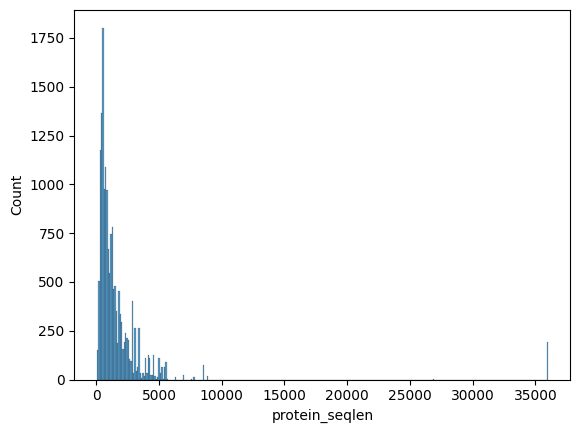

Sequence lengths per annotation: 
count    17019.000000
mean      1809.682296
std       3870.260707
min         52.000000
25%        532.000000
50%        968.000000
75%       1906.000000
max      35991.000000
Name: protein_seqlen, dtype: float64

Sequence lengths per original protein:
count     2878.000000
mean       929.254343
std       1183.577983
min         52.000000
25%        417.250000
50%        631.000000
75%       1086.500000
max      35991.000000
Name: protein_seqlen, dtype: float64

Sequence lengths per variant:
count    16546.000000
mean      1820.127523
std       3910.480344
min         52.000000
25%        532.000000
50%        963.000000
75%       1906.000000
max      35991.000000
Name: protein_seqlen, dtype: float64

90th percentile:  3323.0


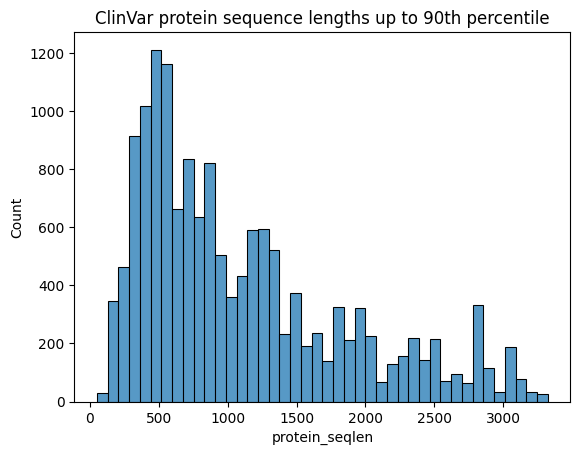

95.0th percentile:  4547.0
98.0th percentile:  5537.0
99.0th percentile:  35991.0


In [50]:
# Check lengths
df_clinvar_clean_mapped['protein_seqlen'] = df_clinvar_clean_mapped['protein_sequence'].str.len()
sns.histplot(df_clinvar_clean_mapped['protein_seqlen'])
plt.show()
print(f"Sequence lengths per annotation: \n{df_clinvar_clean_mapped['protein_seqlen'].describe()}\n")
print(f"Sequence lengths per original protein:\n{df_clinvar_clean_mapped.drop_duplicates(subset='protein_sequence')['protein_seqlen'].describe()}\n")
print(f"Sequence lengths per variant:\n{df_clinvar_clean_mapped.drop_duplicates(subset='protein_sequence_mutated')['protein_seqlen'].describe()}\n")


perc_90 = df_clinvar_clean_mapped['protein_seqlen'].quantile(0.9)
print(f"90th percentile: ", perc_90)

sns.histplot(df_clinvar_clean_mapped['protein_seqlen'][df_clinvar_clean_mapped['protein_seqlen'] <= perc_90])
plt.title("ClinVar protein sequence lengths up to 90th percentile")
# plt.savefig("../saved_files/ClinVar_protein_sequence_lengths_90.png")
plt.show()

for p in [0.95, 0.98, 0.99]:
    perc = df_clinvar_clean_mapped['protein_seqlen'].quantile(p)
    print(f"{p*100}th percentile: ", perc)

In [51]:
# Longest proteins
df_clinvar_clean_mapped.drop_duplicates(subset='protein_sequence').sort_values(by='protein_seqlen', ascending=False).head()

,Name,Gene(s),Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,ribosomal_slippage,transl_table,refseq_mrna_id,coding_pos,has_mrna_mapping,gene_symbol_match,protein_sequence,uniprot_id,protein_sequence_mutated,protein_seqlen
2283,NM_001267550.2(TTN):c.107892_107897del (p.Gln3...,TTN|TTN-AS1,NaN,Tibial muscular dystrophy,"Pathogenic(Last reviewed: Aug 23, 2012)",no assertion criteria provided,VCV000038441,2,179391818 - 179391823,2,...,NaN,NaN,NM_001267550.2,226..108201,True,True,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,{A0A0A0MTS7},MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,35991
2346,NM_003319.4(TTN):c.53810_53833del (p.Gly17937_...,TTN|TTN-AS1,NaN,not specified|not provided,"Uncertain significance(Last reviewed: Apr 20, ...","criteria provided, multiple submitters, no con...",VCV000179275,2,179429831 - 179429854,2,...,NaN,NaN,NM_003319.4,226..81006,True,True,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,None,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,26926
5644,NM_182961.4(SYNE1):c.26266CTC[2] (p.Leu8758del),ESR1|SYNE1,"L8710del, L8758del, L936del","Autosomal recessive ataxia, Beauce type|Emery-...","Uncertain significance(Last reviewed: Sep 24, ...","criteria provided, single submitter",VCV001513254,6,152443691 - 152443693,6,...,NaN,NaN,NM_182961.4,566..26959,True,True,MATSRGASRCPRDIANVMQRLQDEQEIVQKRTFTKWINSHLAKRKP...,{Q9ULF8},MATSRGASRCPRDIANVMQRLQDEQEIVQKRTFTKWINSHLAKRKP...,8797
2067,NM_001164508.2(NEB):c.25534_25535insTATGCACTGT...,NEB|RIF1,NaN,Nemaline myopathy 2,"Uncertain significance(Last reviewed: May 23, ...","criteria provided, single submitter",VCV000552076,2,152342317 - 152342318,2,...,NaN,NaN,NM_001164508.2,193..25770,True,True,MADDEDYEEVVEYYTEEVVYEEVPGETITKIYETTTTRTSDYEQSE...,None,MADDEDYEEVVEYYTEEVVYEEVPGETITKIYETTTTRTSDYEQSE...,8525
5388,NM_001374736.1(DST):c.18094GAG[1] (p.Glu6033del),DST,"E3410del, E3627del, E3736del, E3776del, E3914d...",not provided,"Uncertain significance(Last reviewed: Mar 4, 2...","criteria provided, single submitter",VCV001703969,6,56391189 - 56391191,6,...,NaN,NaN,NM_001374736.1,244..23700,True,True,MIAAAFLVLLRPYSIQCALFLLLLLLGTIATIVFFCCWHRKLQKGR...,{A0A7P0T890},MIAAAFLVLLRPYSIQCALFLLLLLLGTIATIVFFCCWHRKLQKGR...,7818


## Get mutation distances (for later filtering)

In [52]:
# We've done length checks in the respective functions so we can just get the length differences
df_clinvar_clean_mapped['mutation_depth'] = df_clinvar_clean_mapped['protein_sequence_mutated'].str.len() - df_clinvar_clean_mapped['protein_sequence'].str.len()
# For delins, there are subs and indels, so need to treat separately. Would need to align to get the actual depth (for just subs could do hamming distance easily, but for e.g. A1_C3delinsBC this would simply be ABC -> _BC)

# Check all deletions are positive depth
assert (df_clinvar_clean_mapped.loc[df_clinvar_clean_mapped['inframe_del'], 'mutation_depth'] < 0).all()
assert (df_clinvar_clean_mapped.loc[df_clinvar_clean_mapped['inframe_ins'], 'mutation_depth'] > 0).all()

# Note: This (importantly) doesn't include the substitutions in delins :/

In [53]:
assert not df_clinvar_clean_mapped['protein_sequence'].isna().any()
assert not df_clinvar_clean_mapped['protein_sequence_mutated'].isna().any()

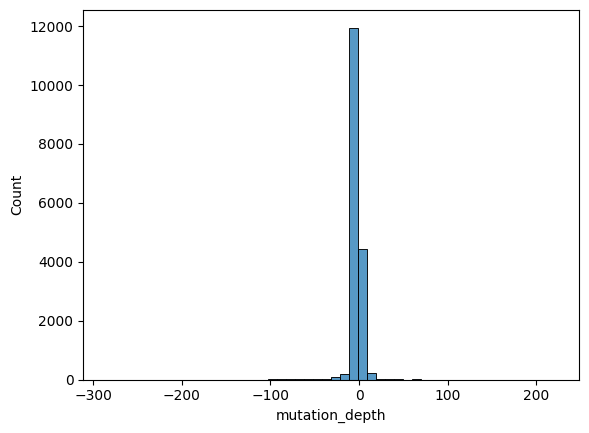

In [54]:
df_clinvar_clean_mapped['mutation_depth'].describe()
sns.histplot(df_clinvar_clean_mapped, x='mutation_depth', bins=50)
plt.show()

In [55]:
# Check those huge protein sequence variants, e.g. PolyQ mutation
cols_subset = ['Name', 'Gene(s)', 'Protein change', 'Clinical significance', 'protein_variant_1letter', 'refseq_mrna_id', 'coding_pos']
df_clinvar_clean_mapped[df_clinvar_clean_mapped['mutation_depth'].abs() > 200][cols_subset]

,Name,Gene(s),Protein change,Clinical significance,protein_variant_1letter,refseq_mrna_id,coding_pos
1880,NM_001378454.1(ALMS1):c.2293_3150del (p.Ser765...,ALMS1,NaN,Uncertain significance,S765_Y1050del,NM_001378454.1,34..12540
3243,NM_001377405.1(ATXN7):c.89AGC[233] (p.Gln39_Pr...,ATXN7|LOC108660406,NaN,Pathogenic,Q39_P40insQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQQ...,NM_001377405.1,403..3081
4375,NM_001205254.2(OCLN):c.52_891del (p.Lys18_Trp2...,OCLN,NaN,NaN,K18_W297del,NM_001205254.2,180..1748
8525,NM_004281.4(BAG3):c.1088_1708del (p.Glu363_Pro...,BAG3,NaN,Likely pathogenic,E363_P569del,NM_004281.4,297..2024
10450,NM_000059.4(BRCA2):c.5199_5909del (p.Glu1734_S...,BRCA2,NaN,Uncertain significance,E1734_S1970del,NM_000059.4,200..10456
16893,NM_001110792.2(MECP2):c.616_1227del (p.Ser206_...,MECP2,NaN,Likely pathogenic,S206_E409del,NM_001110792.2,53..1549
16896,NM_001110792.2(MECP2):c.524_1225del (p.Gly175_...,MECP2,NaN,Pathogenic,G175_S408del,NM_001110792.2,53..1549
16923,NM_001110792.2(MECP2):c.445_1194del (p.Glu149_...,MECP2,M1fs,Pathogenic,E149_L398del,NM_001110792.2,53..1549


Deletions


-1    0.617084
-2    0.095030
-3    0.072408
-4    0.054852
-5    0.038693
-6    0.028561
-7    0.020002
-8    0.016857
Name: mutation_depth, dtype: float64

90th percentile:  -6.0


Text(0.5, 1.0, 'Deletion mutation frequencies up to 90th percentile')

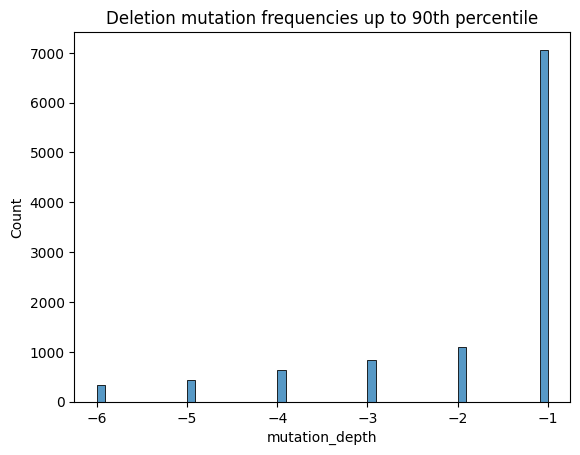

In [56]:
# Deletion mutation depths
print("Deletions")
display(df_clinvar_clean_mapped[df_clinvar_clean_mapped['inframe_del']]['mutation_depth'].value_counts(normalize=True, dropna=False).head(8))
perc_90 = df_clinvar_clean_mapped[df_clinvar_clean_mapped['inframe_del']]['mutation_depth'].quantile(1-0.9)
print(f"90th percentile: ", perc_90)

sns.histplot(df_clinvar_clean_mapped[df_clinvar_clean_mapped['inframe_del'] & (df_clinvar_clean_mapped['mutation_depth'] >= perc_90)], x='mutation_depth')
plt.title("Deletion mutation frequencies up to 90th percentile")

Insertions


1     0.436019
2     0.164297
3     0.102686
4     0.058452
5     0.045024
6     0.041074
7     0.033965
16    0.016588
Name: mutation_depth, dtype: float64

90th percentile:  9.0


Text(0.5, 1.0, 'Insertion mutation frequencies up to 90th percentile')

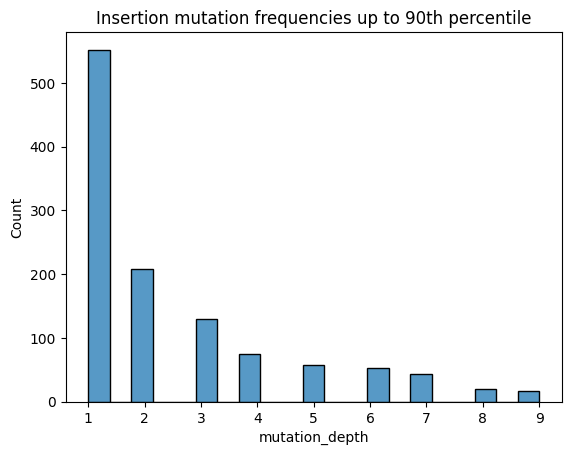

In [57]:
# Insertion mutation depths
print("Insertions")
display(df_clinvar_clean_mapped[df_clinvar_clean_mapped['inframe_ins']]['mutation_depth'].value_counts(normalize=True, dropna=False).head(8))
perc_90 = df_clinvar_clean_mapped[df_clinvar_clean_mapped['inframe_ins']]['mutation_depth'].quantile(0.9)
print(f"90th percentile: ", perc_90)

sns.histplot(df_clinvar_clean_mapped[df_clinvar_clean_mapped['inframe_ins'] & (df_clinvar_clean_mapped['mutation_depth'] <= perc_90)], x='mutation_depth')
plt.title("Insertion mutation frequencies up to 90th percentile")

In [58]:
# Exclude huge insertions / deletions
for depth in [1, 2, 3]:
    num_small_deletions = (df_clinvar_clean_mapped['inframe_del'] & (df_clinvar_clean_mapped['mutation_depth'] >= -depth)).sum()
    print(f"Number of deletions <= {depth} AAs {num_small_deletions} / {df_clinvar_clean_mapped['inframe_del'].sum()} = {num_small_deletions / df_clinvar_clean_mapped['inframe_del'].sum():.2%}")
print()    

for depth in [1, 2, 3]:
    num_small_insertions = (df_clinvar_clean_mapped['inframe_ins'] & (df_clinvar_clean_mapped['mutation_depth'] <= depth)).sum()
    print(f"Number of insertions <= {depth} AAs {num_small_insertions} / {df_clinvar_clean_mapped['inframe_ins'].sum()} = {num_small_insertions / df_clinvar_clean_mapped['inframe_ins'].sum():.2%}")
print()

# Duplications
for depth in [1, 2, 3]:
    num_small_duplications = (df_clinvar_clean_mapped['inframe_dup'] & (df_clinvar_clean_mapped['mutation_depth'] <= depth)).sum()
    print(f"Number of duplications <= {depth} AAs {num_small_duplications} / {df_clinvar_clean_mapped['inframe_dup'].sum()} = {num_small_duplications / df_clinvar_clean_mapped['inframe_dup'].sum():.2%}")
print()

# Duplications and insertions
for depth in [1, 2, 3]:
    num_small_dup_ins = ((df_clinvar_clean_mapped['inframe_ins'] | df_clinvar_clean_mapped['inframe_dup']) & (df_clinvar_clean_mapped['mutation_depth'] <= depth)).sum()
    total_depth = (df_clinvar_clean_mapped['inframe_ins'] | df_clinvar_clean_mapped['inframe_dup']).sum()
    print(f"Number of duplications/insertions <= {depth} AAs {num_small_dup_ins} / {total_depth} = {num_small_dup_ins / total_depth:.2%}")


Number of deletions <= 1 AAs 7065 / 11449 = 61.71%
Number of deletions <= 2 AAs 8153 / 11449 = 71.21%
Number of deletions <= 3 AAs 8982 / 11449 = 78.45%

Number of insertions <= 1 AAs 552 / 1266 = 43.60%
Number of insertions <= 2 AAs 760 / 1266 = 60.03%
Number of insertions <= 3 AAs 890 / 1266 = 70.30%

Number of duplications <= 1 AAs 1345 / 3164 = 42.51%
Number of duplications <= 2 AAs 1854 / 3164 = 58.60%
Number of duplications <= 3 AAs 2191 / 3164 = 69.25%

Number of duplications/insertions <= 1 AAs 1897 / 4430 = 42.82%
Number of duplications/insertions <= 2 AAs 2614 / 4430 = 59.01%
Number of duplications/insertions <= 3 AAs 3081 / 4430 = 69.55%


In [59]:
df_clinvar_clean_mapped['filter_lt_3_aas'] = (df_clinvar_clean_mapped['mutation_depth'].abs() <= 3)
print(f"Mutation depth <= 3 AAs: {df_clinvar_clean_mapped['filter_lt_3_aas'].mean()}")
# Filter both protein_sequence_mutated and protein_sequence (so that we can do relative likelihoods using the model)
max_len = 1022
df_clinvar_clean_mapped['filter_lt_1022_seqlen'] = (df_clinvar_clean_mapped['protein_sequence_mutated'].str.len() <= max_len) & (df_clinvar_clean_mapped['protein_sequence'].str.len() <= max_len)
print(f"Seq len <= 1022: {df_clinvar_clean_mapped['filter_lt_1022_seqlen'].mean()}")

# 95th percentile: 4410
# max_len = 4410
max_len = 6000
df_clinvar_clean_mapped[f'filter_lt_{max_len}_seqlen'] = (df_clinvar_clean_mapped['protein_sequence_mutated'].str.len() <= max_len) & (df_clinvar_clean_mapped['protein_sequence'].str.len() <= max_len)
print(f"Seq len <= {max_len}: {df_clinvar_clean_mapped[f'filter_lt_{max_len}_seqlen'].mean()}")
df_subset_scoring = df_clinvar_clean_mapped[df_clinvar_clean_mapped[f'filter_lt_{max_len}_seqlen'] & df_clinvar_clean_mapped['filter_lt_3_aas']]

Mutation depth <= 3 AAs: 0.7576825900464187
Seq len <= 1022: 0.5173629472942006
Seq len <= 6000: 0.9806099065750044


# Exploration

See the original notebook for more plots/summaries

## 10k deletions, only 1k insertions

In [60]:
df_clinvar_clean_mapped['inframe_ins'].sum()

1266

In [61]:
df_clinvar_clean_mapped['inframe_del'].sum()

11449

In [62]:
df_clinvar_clean_mapped['inframe_delins'].sum()

1140

In [63]:
df_clinvar_clean_mapped['inframe_dup'].sum()

3164

## Check how many genes are labelled

In [64]:
df_subset_scoring['inframe_dup'].value_counts(dropna=False)

False    10442
True      2156
Name: inframe_dup, dtype: int64

In [65]:
def filter_significance(group):
    return (group['Clinical significance'].isin(pathogenic_categories).sum() >= 1)
def filter_significance_2(group):
    return (group['Clinical significance'].isin(pathogenic_categories).sum() >= 2)

print("Number of genes with >= 1 pathogenic/likely pathogenic")
print(df_subset_scoring.groupby("Gene(s)").apply(filter_significance).sum())

print("Number of genes with >= 2 pathogenic/likely pathogenic")
print(df_subset_scoring.groupby("Gene(s)").apply(filter_significance_2).sum())

Number of genes with >= 1 pathogenic/likely pathogenic
890
Number of genes with >= 2 pathogenic/likely pathogenic
322


In [66]:
print("Number of genes with >= 2 stars and >= 1 pathogenic/likely pathogenic")
df_subset_scoring.groupby("Gene(s)").apply(filter_significance_stars).sum()

Number of genes with >= 2 stars and >= 1 pathogenic/likely pathogenic


228

## Check genes with most annotations

In [67]:
# TODO get number of unique variants in these genes (could also print the df)
rows_filtered_genes = df_subset_scoring.groupby("Gene(s)").filter(filter_significance)
rows_filtered_genes["Gene(s)"].unique()

array(['B3GALT6', 'GNB1', 'ESPN', 'PARK7', 'MTHFR', 'PLOD1', 'ATP13A2',
       'SDHB', 'PINK1|PINK1-AS', 'ALPL', 'RPL11', 'SELENON', 'ARID1A',
       'TMEM222', 'GJB3', 'ADPRS', 'YRDC', 'PPT1', 'KCNQ4', 'SLC2A1',
       'SZT2', 'MUTYH', 'MMACHC', 'CPT2', 'NFIA', 'ALG6', 'RPE65',
       'ACADM', 'BCL10', 'GLMN', 'ABCA4', 'AGL', 'COL11A1', 'KCNA2',
       'DRAM2', 'KCND3', 'PSMB4', 'TPM3', 'FLAD1', 'GBA1|LOC106627981',
       'PKLR', 'LMNA', 'NAXE', 'SPTA1', 'UFC1', 'MPZ', 'MYOC', 'SERPINC1',
       'AXDND1|NPHS2', 'NCF2', 'CFH', 'CRB1', 'PTPRC', 'KIF14', 'DDX59',
       'TNNT2', 'SYT2', 'LOC107548112|REN', 'USH2A', 'USH2A|USH2A-AS1',
       'SLC30A10', 'RAB3GAP2', 'WDR26', 'ACTA1', 'RYR2', 'FH', 'ZBTB18',
       'HNRNPU', 'COLEC11', 'KIDINS220', 'NBAS', 'MYCN', 'MATN3', 'APOB',
       'DNMT3A', 'OTOF', 'MPV17', 'IFT172', 'SRD5A2', 'SPAST', 'CYP1B1',
       'SOS1', 'ZFP36L2', 'LRPPRC', 'MSH2', 'MSH6', 'FBXO11',
       'LHCGR|STON1-GTF2A1L', 'BCL11A', 'FIGLA', 'ALMS1', 'BOLA3',
       'HT

In [68]:
significant_rows = rows_filtered_genes[rows_filtered_genes["Clinical significance"].isin(pathogenic_categories+benign_categories)].copy()
significant_rows

,Name,Gene(s),Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,has_mrna_mapping,gene_symbol_match,protein_sequence,uniprot_id,protein_sequence_mutated,protein_seqlen,mutation_depth,filter_lt_3_aas,filter_lt_1022_seqlen,filter_lt_6000_seqlen
26,NM_080605.4(B3GALT6):c.415_423del (p.Met139_Al...,B3GALT6,NaN,"Ehlers-Danlos syndrome, spondylodysplastic typ...","Pathogenic(Last reviewed: Jun 6, 2013)",no assertion criteria provided,VCV000060494,1,1168065 - 1168073,1,...,True,True,MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,{Q5T7M5},MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,329,-3,True,True,True
36,NM_002074.5(GNB1):c.1011_1013del (p.Lys337_Ile...,GNB1,NaN,Inborn genetic diseases,"Pathogenic(Last reviewed: Apr 25, 2016)","criteria provided, single submitter",VCV000521025,1,1718780 - 1718782,1,...,True,True,MSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,"{Q1RMY8, A0A024R056}",MSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,340,-1,True,True,True
79,NM_031475.3(ESPN):c.1803GCC[5] (p.Pro605dup),ESPN,NaN,Autosomal recessive nonsyndromic hearing loss ...,"Likely benign(Last reviewed: Jul 30, 2022)","criteria provided, multiple submitters, no con...",VCV001219107,1,6509036 - 6509037,1,...,True,True,MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,{Q9Y329},MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,854,1,True,True,True
84,NM_031475.3(ESPN):c.2539AAG[1] (p.Lys848del),ESPN,"K818del, K848del, K827del","Deafness, without vestibular involvement, auto...","Pathogenic(Last reviewed: Feb 1, 2006)",no assertion criteria provided,VCV000004423,1,6520179 - 6520181,1,...,True,True,MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,{Q9Y329},MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,854,-1,True,True,True
117,NM_007262.5(PARK7):c.471_473del (p.Pro158del),PARK7,P158del,Autosomal recessive early-onset Parkinson dise...,"Likely pathogenic(Last reviewed: Aug 1, 2022)","criteria provided, multiple submitters, no con...",VCV000987356,1,8045015 - 8045017,1,...,True,True,MASKRALVILAKGAEEMETVIPVDVMRRAGIKVTVAGLAGKDPVQC...,"{V9HWC2, Q7LFU2}",MASKRALVILAKGAEEMETVIPVDVMRRAGIKVTVAGLAGKDPVQC...,189,-1,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17028,NM_001363.5(DKC1):c.1494GAA[5] (p.Lys504_Lys50...,DKC1,NaN,Dyskeratosis congenita,"Benign(Last reviewed: Nov 13, 2020)","criteria provided, single submitter",VCV000800273,X,154005089 - 154005094,X,...,True,True,MADAEVIILPKKHKKKKERKSLPEEDVAEIQHAEEFLIKPESKVAK...,{Q9Y505},MADAEVIILPKKHKKKKERKSLPEEDVAEIQHAEEFLIKPESKVAK...,514,-2,True,True,True
17031,NM_001363.5(DKC1):c.1512_1513insGAA (p.Lys504_...,DKC1,NaN,not provided,"Benign(Last reviewed: Mar 3, 2015)","criteria provided, single submitter",VCV001244861,X,154005109 - 154005110,X,...,True,True,MADAEVIILPKKHKKKKERKSLPEEDVAEIQHAEEFLIKPESKVAK...,{Q9Y505},MADAEVIILPKKHKKKKERKSLPEEDVAEIQHAEEFLIKPESKVAK...,514,1,True,True,True
17032,NM_000132.4(F8):c.6670_6672del (p.Pro2224del),F8,"P2224del, P89del",Hereditary factor VIII deficiency disease,"Pathogenic(Last reviewed: Dec 1, 1993)",no assertion criteria provided,VCV000010323,X,154090044 - 154090046,X,...,True,True,MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...,{Q5HY69},MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...,2351,-1,True,False,True
17034,NM_000132.4(F8):c.2009TCT[2] (p.Phe672del),F8,F672del,Hereditary factor VIII deficiency disease,"Pathogenic(Last reviewed: Feb 1, 1993)",no assertion criteria provided,VCV000010243,X,154176069 - 154176071,X,...,True,True,MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...,{Q5HY69},MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...,2351,-1,True,False,True


In [69]:
significant_rows['Gene(s)'].value_counts()[:30]

ARID1B                32
LDLR                  32
NF1                   29
FOXG1                 21
FOXC1                 20
POLG                  18
PKD1                  16
FBN1                  16
MECP2                 16
MLH1                  14
CREBBP                13
SPTAN1                13
CACNA1A               13
TSC2                  12
AR                    12
NIPBL                 12
FBXO11                12
COL2A1                12
DSPP                  11
LOC102724058|SCN1A    11
ARID1A                11
KMT2D                 11
PRPH2                 10
SCN1A                 10
CDKN1C                10
BRCA1                 10
COMP                   9
PURA                   9
MYO7A                  9
LMNA                   9
Name: Gene(s), dtype: int64

In [70]:
# significant_rows['ClinSigSimple'] = significant_rows["Clinical significance"]
mapper = {"Likely benign": "Benign", "Likely pathogenic": "Pathogenic", "Benign/Likely benign": "Benign", "Pathogenic/Likely pathogenic": "Pathogenic"}
significant_rows['ClinSigSimple'] = significant_rows['Clinical significance'].apply(lambda s: mapper.get(s, s))

<AxesSubplot: xlabel='count', ylabel='Gene(s)'>

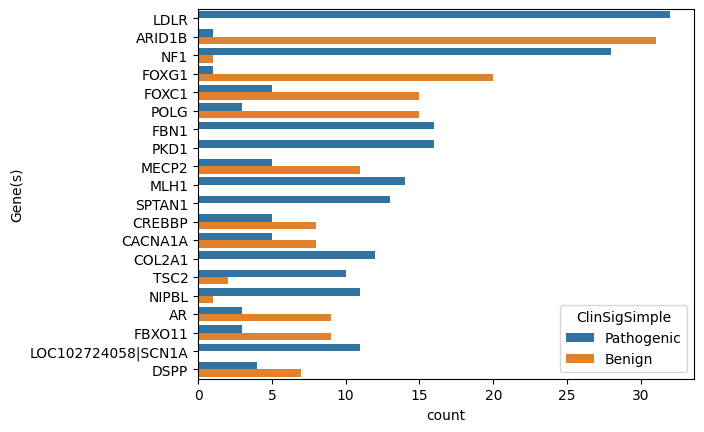

In [71]:
# TODO stacked bar plot of Genes and pathogenic + benign labels
top_genes = significant_rows['Gene(s)'].value_counts()[:20].index
genes_subset = significant_rows[significant_rows['Gene(s)'].isin(top_genes)]
# genes_subset
sns.countplot(data=genes_subset, y="Gene(s)", hue="ClinSigSimple", order=genes_subset['Gene(s)'].value_counts().index, orient='h')

### Check protein lengths per protein

In [72]:
groups = pd.DataFrame(significant_rows.groupby("Gene(s)").size(), columns=['num_annotations']).copy()
groups['seq_len_median'] = significant_rows.groupby("Gene(s)")['protein_seqlen'].median()
groups = groups.sort_values(by='num_annotations', ascending=False)
groups

,num_annotations,seq_len_median
Gene(s),,
ARID1B,32,2372.0
LDLR,32,860.0
NF1,29,2839.0
FOXG1,21,489.0
FOXC1,20,553.0
...,...,...
HSP90AA1,1,732.0
HSPA9,1,679.0
HTRA2,1,458.0


In [73]:
significant_rows[significant_rows["protein_sequence_mutated"].str.contains("Xaa")]

,Name,Gene(s),Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,gene_symbol_match,protein_sequence,uniprot_id,protein_sequence_mutated,protein_seqlen,mutation_depth,filter_lt_3_aas,filter_lt_1022_seqlen,filter_lt_6000_seqlen,ClinSigSimple


## detect STRs

In [74]:
def check_repeating_nucleotides(row):
    chrom, pos, spdi = f"chr{row['GRCh38Chromosome']}", row["GRCh38Location"], row["Canonical SPDI"]
    if not isinstance(pos, str) or not isinstance(spdi, str):
        return None
    elif len(post := pos.split(" - ")) > 1:
        pos1, pos2 = int(post[0]), int(post[1])
    else:
        pos1, pos2 = int(pos), int(pos)
    assert pos2 >= pos1, (pos1, pos2)
    nc, pos, ref, alt = spdi.split(":")
    pos = int(pos)
    mutated_len = max(len(ref), len(alt))
    pos1 = min(pos1, pos)
    pos2 = max(pos2, pos+mutated_len)
    genome_seq = hg38[chrom][pos1-1:pos2].seq
    if any(c.islower() for c in genome_seq):
        return True
    else:
        return False

df_clinvar_clean_mapped["is_repeating"] = df_clinvar_clean_mapped.apply(check_repeating_nucleotides, axis=1)

print(f"Number of repeats: {df_clinvar_clean_mapped['is_repeating'].sum()}")

rows_filtered_genes["is_repeating"] = rows_filtered_genes.apply(check_repeating_nucleotides, axis=1)
significant_rows["is_repeating"] = significant_rows.apply(check_repeating_nucleotides, axis=1)

Number of repeats: 3182


## Write out table of all preprocessed variants

In [75]:
# The genes with >=1 pathogenic, all annotations including uncertain significance annotations
print(len(rows_filtered_genes))
rows_filtered_genes.to_csv(clinvar_filtered_variants_out, index=False)
# Genes with >=1 pathogenic but only pathogenic/benign annotations
print(len(significant_rows))
significant_rows.to_csv(clinvar_only_significant_variants_out, index=False)

# df_clinvar_clean_mapped doesn't have the <=3 AA indels or <=4410 seq_len filters. It doesn't have any filters.
print(len(df_clinvar_clean_mapped))
df_clinvar_clean_mapped.to_csv(clinvar_query_mapped_out, index=False)

6348
2090
17019


# Part 2: Split variants into separate folders, 1 per protein

In [76]:
# TODO(Lood): Dedup protein_sequence_mutated in the second half of the notebook

In [77]:
df = pd.read_csv(file_to_score)

In [78]:
len(df)

2090

In [79]:
df.head()

,Name,Gene(s),Protein change,Condition(s),Clinical significance (Last reviewed),Review status,Accession,GRCh37Chromosome,GRCh37Location,GRCh38Chromosome,...,protein_sequence,uniprot_id,protein_sequence_mutated,protein_seqlen,mutation_depth,filter_lt_3_aas,filter_lt_1022_seqlen,filter_lt_6000_seqlen,ClinSigSimple,is_repeating
0,NM_080605.4(B3GALT6):c.415_423del (p.Met139_Al...,B3GALT6,NaN,"Ehlers-Danlos syndrome, spondylodysplastic typ...","Pathogenic(Last reviewed: Jun 6, 2013)",no assertion criteria provided,VCV000060494,1,1168065 - 1168073,1,...,MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,{'Q5T7M5'},MKLLRRAWRRRAALGLGTLALCGAALLYLARCAAEPGDPRAMSGRS...,329,-3,True,True,True,Pathogenic,False
1,NM_002074.5(GNB1):c.1011_1013del (p.Lys337_Ile...,GNB1,NaN,Inborn genetic diseases,"Pathogenic(Last reviewed: Apr 25, 2016)","criteria provided, single submitter",VCV000521025,1,1718780 - 1718782,1,...,MSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,"{'Q1RMY8', 'A0A024R056'}",MSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,340,-1,True,True,True,Pathogenic,False
2,NM_031475.3(ESPN):c.1803GCC[5] (p.Pro605dup),ESPN,NaN,Autosomal recessive nonsyndromic hearing loss ...,"Likely benign(Last reviewed: Jul 30, 2022)","criteria provided, multiple submitters, no con...",VCV001219107,1,6509036 - 6509037,1,...,MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,{'Q9Y329'},MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,854,1,True,True,True,Benign,True
3,NM_031475.3(ESPN):c.2539AAG[1] (p.Lys848del),ESPN,"K818del, K848del, K827del","Deafness, without vestibular involvement, auto...","Pathogenic(Last reviewed: Feb 1, 2006)",no assertion criteria provided,VCV000004423,1,6520179 - 6520181,1,...,MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,{'Q9Y329'},MALEQALQAARQGELDVLRSLHAAGLLGPSLRDPLDALPVHHAARA...,854,-1,True,True,True,Pathogenic,False
4,NM_007262.5(PARK7):c.471_473del (p.Pro158del),PARK7,P158del,Autosomal recessive early-onset Parkinson dise...,"Likely pathogenic(Last reviewed: Aug 1, 2022)","criteria provided, multiple submitters, no con...",VCV000987356,1,8045015 - 8045017,1,...,MASKRALVILAKGAEEMETVIPVDVMRRAGIKVTVAGLAGKDPVQC...,"{'V9HWC2', 'Q7LFU2'}",MASKRALVILAKGAEEMETVIPVDVMRRAGIKVTVAGLAGKDPVQC...,189,-1,True,True,True,Pathogenic,False


### Split by protein sequence (Tranception will score wrt this)

In [80]:
len(df["protein_sequence"].unique())

861

In [81]:
# Check that each unique protein sequence has a unique gene?
# Some protein sequences shared with multiple genes
# genes_per_protein = df.groupby("protein_sequence").agg({"Gene(s)": "nunique"}).sort_values("Gene(s)", ascending=False)
genes_per_protein = df.groupby("protein_sequence").agg({"gene": "nunique"}).sort_values("gene", ascending=False)
genes_per_protein

# assert (genes_per_protein.values == 1).all()
# prot1 = genes_per_protein.index[0]
# print(df[df["protein_sequence"] == prot1]["Gene(s)"].unique())

,gene
protein_sequence,
MAAAAAAAAAAGAAGGRGSGPGRRRHLVPGAGGEAGEGAPGGAGDYGNGLESEELEPEELLLEPEPEPEPEEEPPRPRAPPGAPGPGPGSGAPGSQEEEEEPGLVEGDPGDGAIEDPELEAIKARVREMEEEAEKLKELQNEVEKQMNMSPPPGNAGPVIMSIEEKMEADARSIYVGNVDYGATAEELEAHFHGCGSVNRVTILCDKFSGHPKGFAYIEFSDKESVRTSLALDESLFRGRQIKVIPKRTNRPGISTTDRGFPRARYRARTTNYNSSRSRFYSGFNSRPRGRVYRGRARATSWYSPY,1
MPAMPSSGPGDTSSSAAEREEDRKDGEEQEEPRGKEERQEPSTTARKVGRPGRKRKHPPVESGDTPKDPAVISKSPSMAQDSGASELLPNGDLEKRSEPQPEEGSPAGGQKGGAPAEGEGAAETLPEASRAVENGCCTPKEGRGAPAEAGKEQKETNIESMKMEGSRGRLRGGLGWESSLRQRPMPRLTFQAGDPYYISKRKRDEWLARWKREAEKKAKVIAGMNAVEENQGPGESQKVEEASPPAVQQPTDPASPTVATTPEPVGSDAGDKNATKAGDDEPEYEDGRGFGIGELVWGKLRGFSWWPGRIVSWWMTGRSRAAEGTRWVMWFGDGKFSVVCVEKLMPLSSFCSAFHQATYNKQPMYRKAIYEVLQVASSRAGKLFPVCHDSDESDTAKAVEVQNKPMIEWALGGFQPSGPKGLEPPEEEKNPYKEVYTDMWVEPEAAAYAPPPPAKKPRKSTAEKPKVKEIIDERTRERLVYEVRQKCRNIEDICISCGSLNVTLEHPLFVGGMCQNCKNCFLECAYQYDDDGYQSYCTICCGGREVLMCGNNNCCRCFCVECVDLLVGPGAAQAAIKEDPWNCYMCGHKGTYGLLRRREDWPSRLQMFFANNHDQEFDPPKVYPPVPAEKRKPIRVLSLFDGIATGLLVLKDLGIQVDRYIASEVCEDSITVGMVRHQGKIMYVGDVRSVTQKHIQEWGPFDLVIGGSPCNDLSIVNPARKGLYEGTGRLFFEFYRLLHDARPKEGDDRPFFWLFENVVAMGVSDKRDISRFLESNPVMIDAKEVSAAHRARYFWGNLPGMNRPLASTVNDKLELQECLEHGRIAKFSKVRTITTRSNSIKQGKDQHFPVFMNEKEDILWCTEMERVFGFPVHYTDVSNMSRLARQRLLGRSWSVPVIRHLFAPLKEYFACV,1
MPAPTQLFFPLIRNCELSRIYGTACYCHHKHLCCSSSYIPQSRLRYTPHPAYATFCRPKENWWQYTQGRRYASTPQKFYLTPPQVNSILKANEYSFKVPEFDGKNVSSILGFDSNQLPANAPIEDRRSAATCLQTRGMLLGVFDGHAGCACSQAVSERLFYYIAVSLLPHETLLEIENAVESGRALLPILQWHKHPNDYFSKEASKLYFNSLRTYWQELIDLNTGESTDIDVKEALINAFKRLDNDISLEAQVGDPNSFLNYLVLRVAFSGATACVAHVDGVDLHVANTGDSRAMLGVQEEDGSWSAVTLSNDHNAQNERELERLKLEHPKSEAKSVVKQDRLLGLLMPFRAFGDVKFKWSIDLQKRVIESGPDQLNDNEYTKFIPPNYHTPPYLTAEPEVTYHRLRPQDKFLVLATDGLWETMHRQDVVRIVGEYLTGMHHQQPIAVGGYKVTLGQMHGLLTERRTKMSSVFEDQNAATHLIRHAVGNNEFGTVDHERLSKMLSLPEELARMYRDDITIIVVQFNSHVVGAYQNQE,1
MPAVASVPKELYLSSSLKDLNKKTEVKPEKISTKSYVHSALKIFKTAEECRLDRDEERAYVLYMKYVTVYNLIKKRPDFKQQQDYFHSILGPGNIKKAVEEAERLSESLKLRYEEAEVRKKLEEKDRQEEAQRLQQKRQETGREDGGTLAKGSLENVLDSKDKTQKSNGEKNEKCETKEKGAITAKELYTMMTDKNISLIIMDARRMQDYQDSCILHSLSVPEEAISPGVTASWIEAHLPDDSKDTWKKRGNVEYVVLLDWFSSAKDLQIGTTLRSLKDALFKWESKTVLRNEPLVLEGGYENWLLCYPQYTTNAKVTPPPRRQNEEVSISLDFTYPSLEESIPSKPAAQTPPASIEVDENIELISGQNERMGPLNISTPVEPVAASKSDVSPIIQPVPSIKNVPQIDRTKKPAVKLPEEHRIKSESTNHEQQSPQSGKVIPDRSTKPVVFSPTLMLTDEEKARIHAETALLMEKNKQEKELRERQQEEQKEKLRKEEQEQKAKKKQEAEENEITEKQQKAKEEMEKKESEQAKKEDKETSAKRGKEITGVKRQSKSEHETSDAKKSVEDRGKRCPTPEIQKKSTGDVPHTSVTGDSGSGKPFKIKGQPESGILRTGTFREDTDDTERNKAQREPLTRARSEEMGRIVPGLPSGWAKFLDPITGTFRYYHSPTNTVHMYPPEMAPSSAPPSTPPTHKAKPQIPAERDREPSKLKRSYSSPDITQAIQEEEKRKPTVTPTVNRENKPTCYPKAEISRLSASQIRNLNPVFGGSGPALTGLRNLGNTCYMNSILQCLCNAPHLADYFNRNCYQDDINRSNLLGHKGEVAEEFGIIMKALWTGQYRYISPKDFKITIGKINDQFAGYSQQDSQELLLFLMDGLHEDLNKADNRKRYKEENNDHLDDFKAAEHAWQKHKQLNESIIVALFQGQFKSTVQCLTCHKKSRTFEAFMYLSLPLASTSKCTLQDCLRLFSKEEKLTDNNRFYCSHCRARRDSLKKIEIWKLPPVLLVHLKRFSYDGRWKQKLQTSVDFPLENLDLSQYVIGPKNNLKKYNLFSVSNHYGGLDGGHYTAYCKNAARQRWFKFDDHEVSDISVSSVKSSAAYILFYTSLGPRVTDVAT,1
MPDTMLPACFLGLLAFSSACYFQNCPRGGKRAMSDLELRQCLPCGPGGKGRCFGPSICCADELGCFVGTAEALRCQEENYLPSPCQSGQKACGSGGRCAAFGVCCNDESCVTEPECREGFHRRARASDRSNATQLDGPAGALLLRLVQLAGAPEPFEPAQPDAY,1
...,...
MEEQVFKGDPDTPHSISFSGSGFLSFYQAGAVDALRDLAPRMLETAHRFAGTSAGAVIAALAICGIEMDEYLRVLNVGVAEVKKSFLGPLSPSCKMVQMMRQFLYRVLPEDSYKVTTGKLHVSLTRLTDGENVVVSEFTSKEELIEALYCSCFVPVYCGLIPPTYRGVRYIDGGFTGMQPCAFWTDAITISTFSGQQDICPRDCPAIFHDFRMFNCSFQFSLENIARMTHALFPPDLVILHDYYYRGYEDAVLYLRRLNAVYLNSSSKRVIFPRVEVYCQIELALGNECPERSQPSLRARQASLEGATQPHKEWVPKGDGRGSHGPPVSQPVQTLEFTCESPVSAPVSPLEQPPAQPLASSTPLSLSGMPPVSFPAVHKPPSSTPGSSLPTPPPGLSPLSPQQQVQPSGSPARSLHSQAPTSPRPSLGPSTVGAPQTLPRSSLSAFPAQPPVEELGQEQPQAVALLVSSKPKSAVPLVHVKETVSKPYVTESPAEDSNWVNKVFKKNKQKTSGTRKGFPRHSGSKKPSSKVQSAPCPLNFPLLSTSETVWVTYRPHPSRIQECCPEVWNSLG,1
MEFPIGSLETNNFRRFTPESLVEIEKQIAAKQGTKKAREKHREQKDQEEKPRPQLDLKACNQLPKFYGELPAELIGEPLEDLDPFYSTHRTFMVLNKGRTISRFSATRALWLFSPFNLIRRTAIKVSVHSWFSLFITVTILVNCVCMTRTDLPEKIEYVFTVIYTFEALIKILARGFCLNEFTYLRDPWNWLDFSVITLAYVGTAIDLRGISGLRTFRVLRALKTVSVIPGLKVIVGALIHSVKKLADVTILTIFCLSVFALVGLQLFKGNLKNKCVKNDMAVNETTNYSSHRKPDIYINKRGTSDPLLCGNGSDSGHCPDGYICLKTSDNPDFNYTSFDS

In [82]:
# Check multiple protein sequences per gene?  
# KRAS and ALMS1, rest are fine
display(df.groupby("gene").agg({"protein_sequence": "nunique"}).sort_values("protein_sequence", ascending=False))

# And lastly, any protein sequences split between non-alias genes?
def all_genes_related(genes):
    if len(genes) == 1 or genes is None:
        return True
    # Two or more genes
    for i in range(len(genes)):
        aliases = genes[i].split("|")
        for j in range(i+1, len(genes)):
            aliases_j = genes[j].split("|")
            if not any(a in aliases_j for a in aliases):
                return False
    return True


genes_related = df.groupby(["protein_sequence"])["gene"].unique().apply(all_genes_related)

# assert genes_related.all()

# 1 sequence with two different genes (have manually checked these sequences are the same)
problem_sequence = "MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"
df[df["protein_sequence"] == problem_sequence][["refseq_protein_id", "gene"]]

,protein_sequence
gene,
PTCH1,2
CACNA1D,2
KRAS,2
PLEC,2
ALMS1,2
...,...
FOXG1,1
FOXL2,1
FOXP3,1


,refseq_protein_id,gene
1389,NP_000508.1,HBA2
1390,NP_000508.1,HBA2


## Save each protein's variants separately in subfolders for generating model predictions

In [83]:
# making a unique refseq id column (combining the few cases where there are two refseq ids for one protein)
def make_refseq_unique(group):
    assert len(group["protein_sequence"].unique()) == 1
    if len(group["refseq_protein_id"].unique()) != 1:
        group["refseq_unique_id"] = "-".join(group["refseq_protein_id"].unique().tolist())
    else:
        group["refseq_unique_id"] = group["refseq_protein_id"]
    return group
df_unique_refseq = df.groupby("protein_sequence", group_keys=True).apply(make_refseq_unique)

In [84]:
import os
assert os.path.isdir(per_protein_out_folder)

## Using refeq id as identifier instead 
counter = 0
unique_refseq_to_protein = []

for refseq_protein_id in df_unique_refseq["refseq_unique_id"].unique():
    subset = df_unique_refseq[df_unique_refseq["refseq_unique_id"] == refseq_protein_id]
    protein_sequences = subset["protein_sequence"].unique()
    assert len(protein_sequences) == 1, "There should only be one unique protein_sequence per refseq id"
    
    counter += len(subset)
    subset.to_csv(os.path.join(per_protein_out_folder, f"{refseq_protein_id}.csv"), index=False)
    # Save RefSeq - protein mapping
    seq = protein_sequences[0]
    unique_refseq_to_protein.append({"protein_sequence": seq, "refseq_unique_id": refseq_protein_id})

print(f"{counter} variants processed across {df_unique_refseq['refseq_unique_id'].nunique()} unique refseq ids")
df_refseq_to_protein = pd.DataFrame(unique_refseq_to_protein)

# Sanity check that all rows were processed
assert counter == len(df)

2090 variants processed across 861 unique refseq ids


In [85]:
# Sanity check that all the files were written out
filepath = per_protein_out_folder
for refseq_protein_id in df_unique_refseq["refseq_unique_id"].unique():
    if not os.path.exists(f"{filepath}/{refseq_protein_id}.csv"):
        print(refseq_protein_id)


## Create a table containing all the paths to score, for Tranception

In [86]:
# Add other fields in ProteinGym format:
df_tranception_mapping = pd.DataFrame()
df_tranception_mapping["target_sequence_id"] = df_refseq_to_protein["refseq_unique_id"]
df_tranception_mapping["target_sequence_filename"] = df_refseq_to_protein["refseq_unique_id"] + ".csv"
df_tranception_mapping["target_seq"] = df_refseq_to_protein["protein_sequence"]
df_tranception_mapping["dataset_folder"] = per_protein_out_folder
df_tranception_mapping["mutated_sequence_column"] = "protein_sequence_mutated"
df_tranception_mapping["MSA_filename"] = df_refseq_to_protein["refseq_unique_id"] + ".a2m"
for id_val in df_refseq_to_protein["refseq_unique_id"]:
    filenames = os.listdir("/n/groups/marks/projects/indels_human/indels_benchmark/alignments/focus_column_only/ClinVar") 
    assert id_val + ".a2m" in filenames 
df_tranception_mapping["weight_file_name"] = None 
df_tranception_mapping["MSA_start"] = 1 
df_tranception_mapping["MSA_end"] = df_tranception_mapping["target_seq"].apply(len)
df_tranception_mapping = df_tranception_mapping.sort_values(by="target_sequence_id")

# TODO(Daniel): Add other fields if necessary?
# Save to CSV
df_tranception_mapping.to_csv(tranception_refseq_id_file, index=False)
# df_tranception_mapping

### Save fasta file of protein sequences

In [87]:
with open(fasta_refseq_sequences, "w") as f:
    for i, row in df_unique_refseq.drop_duplicates("refseq_unique_id").sort_values(by="refseq_unique_id").iterrows():
        if i != 0:
            f.write("\n")
        f.write(f">{row['refseq_unique_id']}\n{row['protein_sequence']}")
!head {fasta_refseq_sequences}


>NP_000007.1
MAAGFGRCCRVLRSISRFHWRSQHTKANRQREPGLGFSFEFTEQQKEFQATARKFAREEIIPVAAEYDKTGEYPVPLIRRAWELGLMNTHIPENCGGLGLGTFDACLISEELAYGCTGVQTAIEGNSLGQMPIIIAGNDQQKKKYLGRMTEEPLMCAYCVTEPGAGSDVAGIKTKAEKKGDEYIINGQKMWITNGGKANWYFLLARSDPDPKAPANKAFTGFIVEADTPGIQIGRKELNMGQRCSDTRGIVFEDVKVPKENVLIGDGAGFKVAMGAFDKTRPVVAAGAVGLAQRALDEATKYALERKTFGKLLVEHQAISFMLAEMAMKVELARMSYQRAAWEVDSGRRNTYYASIAKAFAGDIANQLATDAVQILGGNGFNTEYPVEKLMRDAKIYQIYEGTSQIQRLIVAREHIDKYKN
>NP_000008.1
MAAALLARASGPARRALCPRAWRQLHTIYQSVELPETHQMLLQTCRDFAEKELFPIAAQVDKEHLFPAAQVKKMGGLGLLAMDVPEELGGAGLDYLAYAIAMEEISRGCASTGVIMSVNNSLYLGPILKFGSKEQKQAWVTPFTSGDKIGCFALSEPGNGSDAGAASTTARAEGDSWVLNGTKAWITNAWEASAAVVFASTDRALQNKGISAFLVPMPTPGLTLGKKEDKLGIRGSSTANLIFEDCRIPKDSILGEPGMGFKIAMQTLDMGRIGIASQALGIAQTALDCAVNYAENRMAFGAPLTKLQVIQFKLADMALALESARLLTWRAAMLKDNKKPFIKEAAMAKLAASEAATAISHQAIQILGGMGYVTEMPAERHYRDARITEIYEGTSEIQRLVIAGHLLRSYRS
>NP_000009.1
MQAARMAASLGRQLLRLGGGSSRLTALLGQPRPGPARRPYAGGAAQLALDKSDSHPSDALTRKKPAKAESKSFAVGMFKGQLTTDQVFPYPSVLNEEQTQFLKELVEPVSRFFEEVNDPAKNDAL

See Old_Step2_split_variants for the previous methods to match sequences with gene aliases

In [88]:
end = time.perf_counter()
elapsed = end-start
print(f"Preprocessing notebook finished in {int(elapsed//60)}m{elapsed%60:.2f}s")

Preprocessing notebook finished in 1m15.46s
